In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 1. Simulate trend + seasonality + noise
np.random.seed(2024)
n = 100
t = np.arange(1, n+1)
time_index = pd.date_range("2000-01-01", periods=n, freq="ME")

mu = -5 + 0.1 * t                       # 線性趨勢
ss = np.sin(2 * np.pi * t / 12)         # 每 12 期的季節性
e = 0.5 * np.random.randn(n)            # 隨機噪音
y = mu + ss + e

df = pd.DataFrame({"y": y, "signal": mu + ss}, index=time_index)

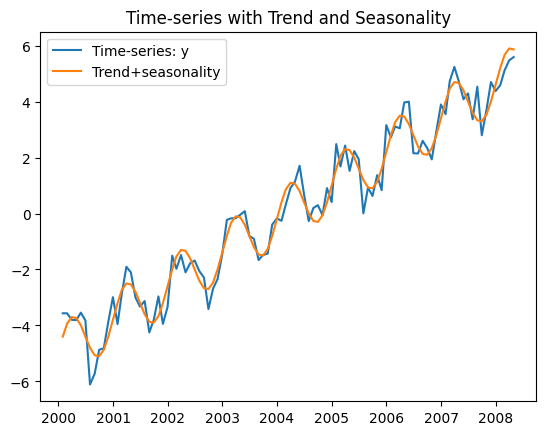

In [3]:
plt.figure()
plt.plot(df.index, df["y"], label="Time-series: y")
plt.plot(df.index, df["signal"], label="Trend+seasonality")
plt.legend()
plt.title("Time-series with Trend and Seasonality");

In [4]:
# 2. 去除趨勢與季節性：一次回歸 + 正餘弦基底
# 趨勢項
X_trend = sm.add_constant(t)
trend_mod = sm.OLS(y, X_trend).fit()
trend_fitted = trend_mod.fittedvalues

# 季節項（正餘弦雙基底）
X_season = np.column_stack([np.sin(2*np.pi*t/12), np.cos(2*np.pi*t/12)])
X_full = sm.add_constant(np.column_stack([t, X_season]))
full_mod = sm.OLS(y, X_full).fit()
residual = full_mod.resid

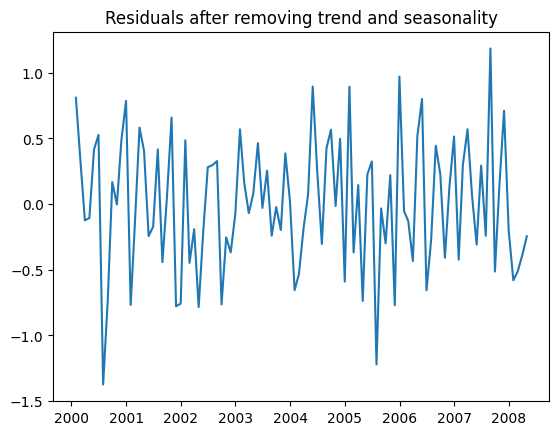

In [5]:
#"移除趨勢與季節性後的殘差
plt.figure()
plt.plot(df.index, residual)
plt.title("Residuals after removing trend and seasonality");

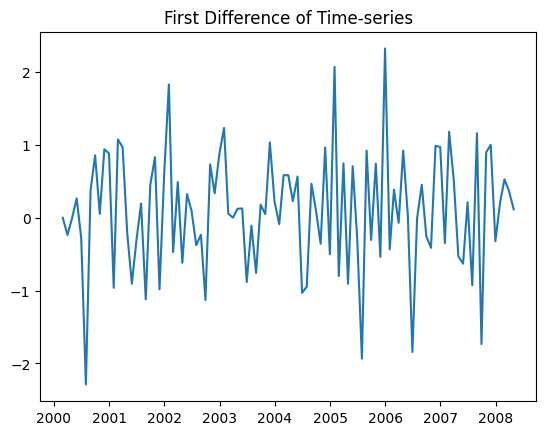

In [6]:
# 3. 一階差分示範（去除趨勢）
d1 = np.diff(y)
plt.figure()
plt.plot(time_index[1:], d1)
plt.title("First Difference of Time-series");

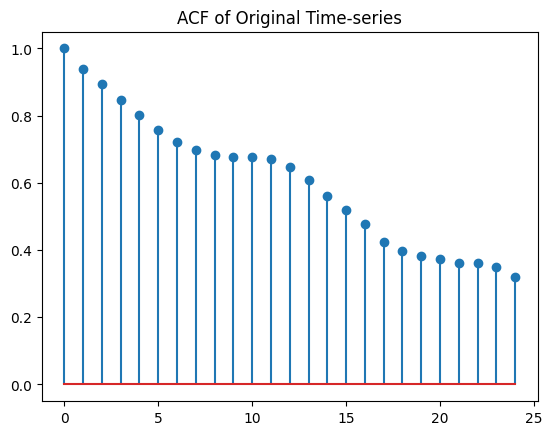

In [7]:
# 4. 模型識別：ACF
acf_orig = acf(y, nlags=24)
acf_resid = acf(residual, nlags=24)
plt.figure()
plt.stem(range(len(acf_orig)), acf_orig)
plt.title("ACF of Original Time-series");


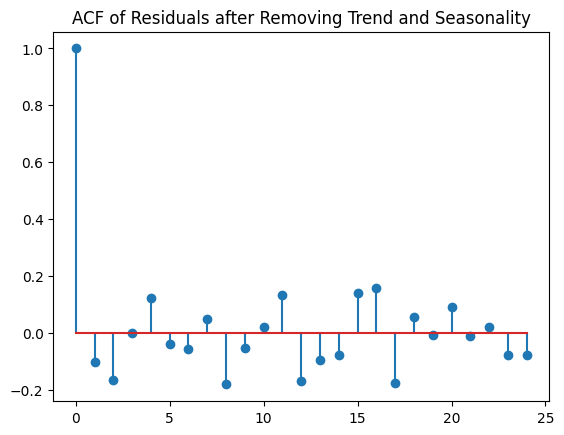

In [8]:
plt.figure()
plt.stem(range(len(acf_resid)), acf_resid)
plt.title("ACF of Residuals after Removing Trend and Seasonality");

In [16]:
# 5. AR(1) 模擬與理論 vs 樣本 ACF/PACF
phi1 = 0.8
ar1 = np.array([1, -phi1])  # AR polynomial coefficients: 1 - phi1 * B
ma1 = np.array([1])         # MA(0)
AR1 = ArmaProcess(ar1, ma1)
y1 = AR1.generate_sample(nsample=200, scale=1.0)

# 理論與樣本 ACF
theo_acf1 = AR1.acf(lags=10)
samp_acf1 = acf(y1, nlags=10)

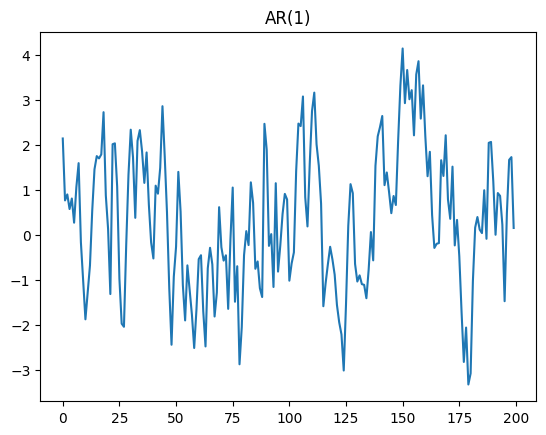

In [17]:
plt.figure()
plt.plot(y1)
plt.title("AR(1)");

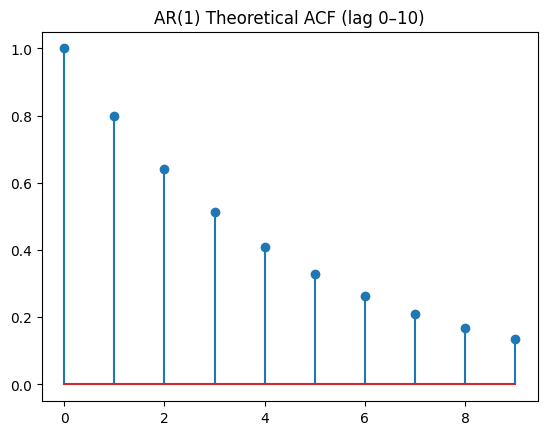

In [18]:
plt.figure()
plt.stem(range(len(theo_acf1)), theo_acf1)
plt.title("AR(1) Theoretical ACF (lag 0–10)");

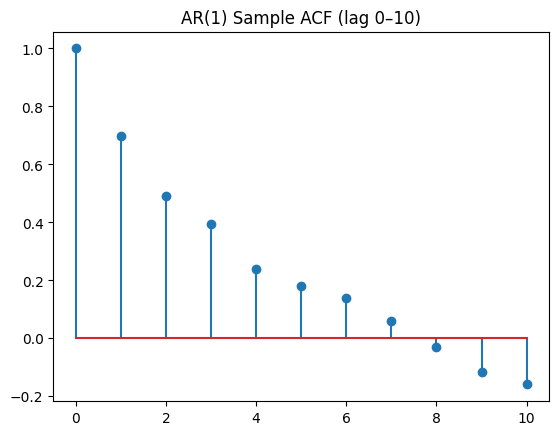

In [19]:
plt.figure()
plt.stem(range(len(sam_acf1)), sam_acf1)
plt.title("AR(1) Sample ACF (lag 0–10)");

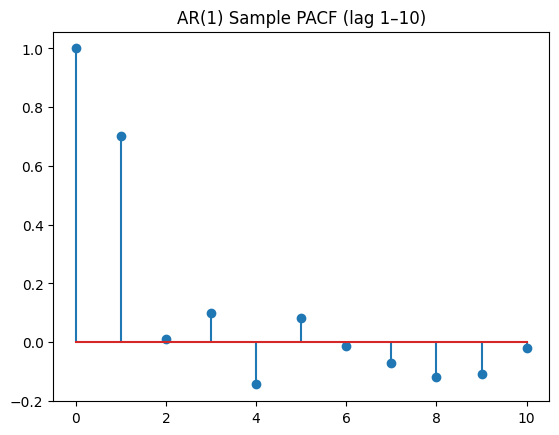

In [20]:
plt.figure()
plt.stem(range(len(sam_pacf1)), sam_pacf1)
plt.title("AR(1) Sample PACF (lag 1–10)");

In [21]:
# --- 2. AR(2) with phi1=0.3, phi2=0.4 ---
phi = np.array([0.3, 0.4])
ar2 = np.r_[1, -phi]  # [1, -phi1, -phi2]
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
y2 = AR2.generate_sample(nsample=200, scale=1.0)

theo_acf2 = AR2.acf(lags=10)
samp_acf2 = acf(y2, nlags=10)


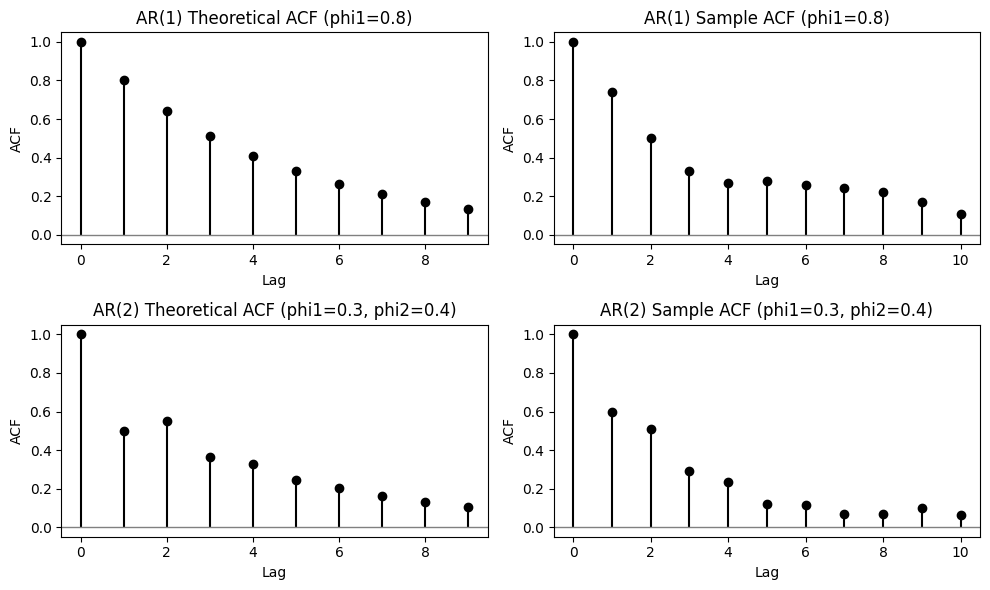

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# AR(1) ACF
axes[0,0].stem(range(len(theo_acf1)), theo_acf1, basefmt=" ", linefmt="black")
axes[0,0].set_title("AR(1) Theoretical ACF (phi1=0.8)")
axes[0,1].stem(range(len(samp_acf1)), samp_acf1, basefmt=" ", linefmt="black")
axes[0,1].set_title("AR(1) Sample ACF (phi1=0.8)")

# AR(2) ACF
axes[1,0].stem(range(len(theo_acf2)), theo_acf2, basefmt=" ", linefmt="black")
axes[1,0].set_title("AR(2) Theoretical ACF (phi1=0.3, phi2=0.4)")
axes[1,1].stem(range(len(samp_acf2)), samp_acf2, basefmt=" ", linefmt="black")
axes[1,1].set_title("AR(2) Sample ACF (phi1=0.3, phi2=0.4)")

for ax in axes.flatten():
    ax.axhline(0, color='gray', lw=1)
    ax.set_xlabel("Lag")
    ax.set_ylabel("ACF")

plt.tight_layout()
plt.show()


In [4]:
# 數據模擬
n = 100
t = np.arange(1, n + 1)
y6 = np.random.normal(loc=np.sin(t / 10), scale=0.5)

# 拟合 AR(1) 模型
fit1 = ARIMA(y6, order=(1, 0, 0)).fit()
resid1 = fit1.resid
fitted1 = y6 - resid1

# 拟合 IMA(1) 模型 ≈ ARIMA(0,1,1)
fit2 = ARIMA(y6, order=(0, 1, 1)).fit()
resid2 = fit2.resid
fitted2 = y6 - resid2
ma1_coef = fit2.params[0]  # IMA(1) 中的 ma.L1 係數

# EWMA 實作
def ewma_forecast(y, lambda_):
    pred = np.zeros_like(y)
    pred[0] = y[0]
    for i in range(1, len(y)):
        pred[i] = lambda_ * y[i-1] + (1 - lambda_) * pred[i-1]
    return pred

lambda_est = 1 + ma1_coef
ewma1 = ewma_forecast(y6, lambda_=lambda_est)
ewma2 = ewma_forecast(y6, lambda_=0.1)

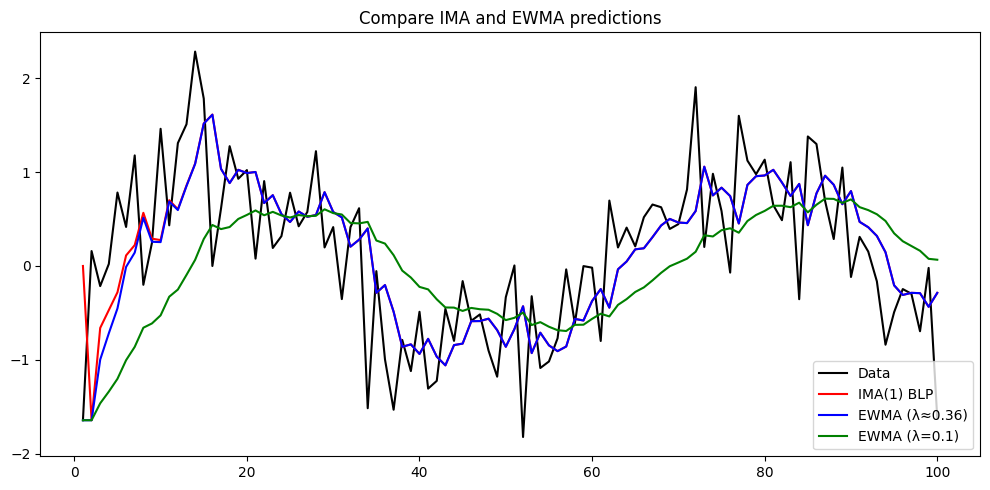

In [5]:
# 繪圖：比較原始資料與 IMA + EWMA 模型預測
plt.figure(figsize=(10, 5))
plt.plot(t, y6, label="Data", color='black')
plt.plot(t, fitted2, label="IMA(1) BLP", color='red')
plt.plot(t, ewma1, label=f"EWMA (λ≈{lambda_est:.2f})", color='blue')
plt.plot(t, ewma2, label="EWMA (λ=0.1)", color='green')
plt.legend(loc="lower right")
plt.title("Compare IMA and EWMA predictions")
plt.tight_layout()
plt.show()

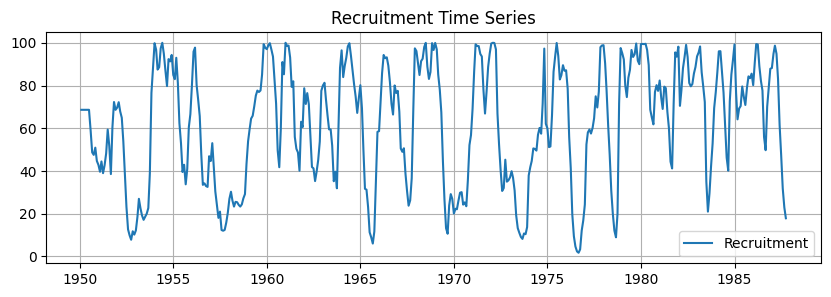

In [20]:
# =============================================================================
# 1. 讀取資料 & 初步探索 (EDA)
# =============================================================================

# 1.1 Recruitment 月度資料
rec_df = pd.read_csv('rec.csv', index_col=0)
# 整齊展平成一維、轉成浮點數
rec = rec_df.values.astype(float).flatten()
rec_index = pd.date_range('1950-01', periods=len(rec), freq='M')
rec_ts = pd.Series(rec, index=rec_index)

# 1.2 繪製時間序列
plt.figure(figsize=(10,3))
plt.plot(rec_ts, label='Recruitment'); plt.title('Recruitment Time Series'); plt.grid(); plt.legend()
plt.show()

In [ ]:
# === Load Lynx Data ===
lynx_data = pd.read_csv("./lynx.csv", index_col=0)
lynx = lynx_data['x'].values.flatten()
lynx_index = pd.date_range(start="1821", periods=len(lynx), freq="Y")
lynx_ts = pd.Series(lynx, index=lynx_index)

In [ ]:
# import ace_tools_open as tools; 
# tools.display_dataframe_to_user(name="REC Data", dataframe=rec_data)
# tools.display_dataframe_to_user(name="Lynx Data", dataframe=lynx_data)

In [7]:
rec_ts

1950-01-31    68.63
1950-02-28    68.63
1950-03-31    68.63
1950-04-30    68.63
1950-05-31    68.63
              ...  
1987-05-31    61.42
1987-06-30    47.47
1987-07-31    31.81
1987-08-31    22.95
1987-09-30    17.87
Freq: ME, Length: 453, dtype: float64

In [21]:
# 1.3 檢定平穩性 (ADF Test)
stat, pval, *_ = adfuller(rec_ts)
print(f'ADF test p-value = {pval:.4f}  →', '平穩' if pval<0.05 else '非平穩')


ADF test p-value = 0.0000  → 平穩


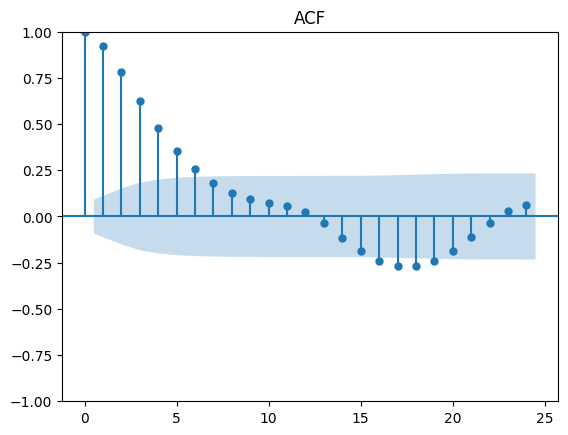

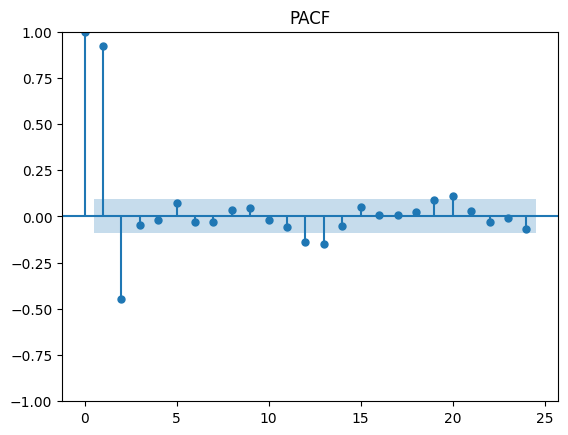

In [ ]:
# =============================================================================
# 2. 用 ACF / PACF 初步判斷模型階數
# =============================================================================

# 2.1 ACF：若在 lag ≈ q 後截斷 → MA(q)
plot_acf(rec_ts, lags=24, title='ACF')
plt.show()

# 2.2 PACF（偏自相關函數）：若在 lag ≈ p 後截斷 → AR(p)
plot_pacf(rec_ts, lags=24, method='ywm', title='PACF')
plt.show()

# 由 PACF 在 lag=1,2 截斷，可初步決定用 AR(2)

In [23]:
# =============================================================================
# 3. 用 OLS 重現 ar.ols(rec, order=2, ...) （Yule-Walker 類似）
# =============================================================================

# 3.1 準備 AR(2) 資料：y_t 對 X = [1, y_{t-1}, y_{t-2}]
y = rec[2:]
X = np.column_stack([rec[1:-1], rec[0:-2]]).astype(float)
X = sm.add_constant(X)  # 加入截距
# 使用 OLS 估計
ols_mod = sm.OLS(y, X).fit()
print(ols_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     1734.
Date:                Fri, 20 Jun 2025   Prob (F-statistic):          1.21e-211
Time:                        15:16:50   Log-Likelihood:                -1653.9
No. Observations:                 451   AIC:                             3314.
Df Residuals:                     448   BIC:                             3326.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7371      1.114      6.046      0.0

In [24]:
# =============================================================================
# 4. 用 MLE 拟合 ARIMA(2,0,0)（對應 R: arima(rec, order=c(2,0,0))）
# =============================================================================

arima_mod = ARIMA(rec_ts, order=(2,0,0)).fit()
print(arima_mod.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  453
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1661.510
Date:                Fri, 20 Jun 2025   AIC                           3331.019
Time:                        15:17:12   BIC                           3347.483
Sample:                    01-31-1950   HQIC                          3337.506
                         - 09-30-1987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.8939      4.123     15.013      0.000      53.814      69.974
ar.L1          1.3512      0.041     32.952      0.000       1.271       1.432
ar.L2         -0.4612      0.037    -12.398      0.0

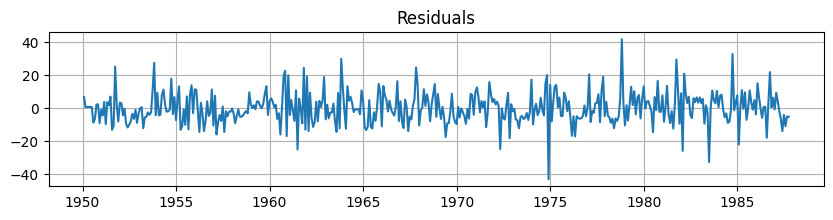

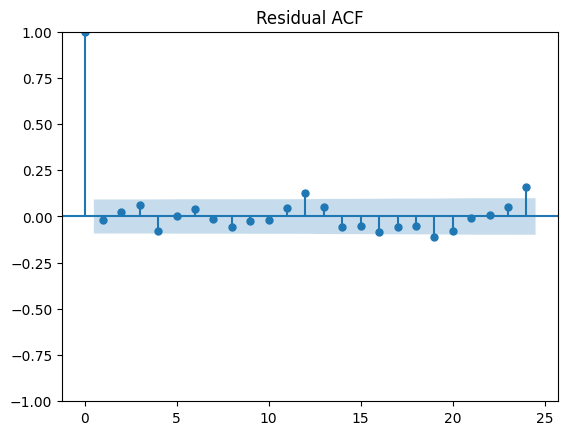

In [25]:
# =============================================================================
# 5. 殘差診斷 & 白噪音檢定
# =============================================================================

resid = arima_mod.resid.dropna()

# 5.1 殘差時序圖
plt.figure(figsize=(10,2))
plt.plot(resid); plt.title('Residuals'); plt.grid(); plt.show()

# 5.2 殘差 ACF：應該接近白噪音
plot_acf(resid, lags=24, title='Residual ACF')
plt.show()


In [26]:
# 5.3 Ljung-Box 檢定：若 p > 0.05，表示殘差無自相關
lb = acorr_ljungbox(resid, lags=[6,12], return_df=True)
print('Ljung-Box Test:\n', lb)

Ljung-Box Test:
       lb_stat  lb_pvalue
6    5.428211   0.490176
12  15.643163   0.208132


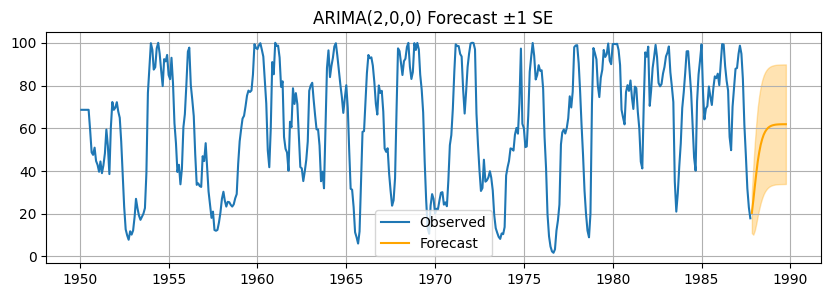

In [27]:
# =============================================================================
# 6. 預測 (Forecast) 與信賴區間
# =============================================================================

fc = arima_mod.get_forecast(steps=24)
mean = fc.predicted_mean
se   = fc.se_mean

plt.figure(figsize=(10,3))
plt.plot(rec_ts, label='Observed')
plt.plot(mean.index, mean, label='Forecast', color='orange')
plt.fill_between(mean.index, mean-se, mean+se, color='orange', alpha=0.3)
plt.title('ARIMA(2,0,0) Forecast ±1 SE'); plt.legend(); plt.grid(); plt.show()

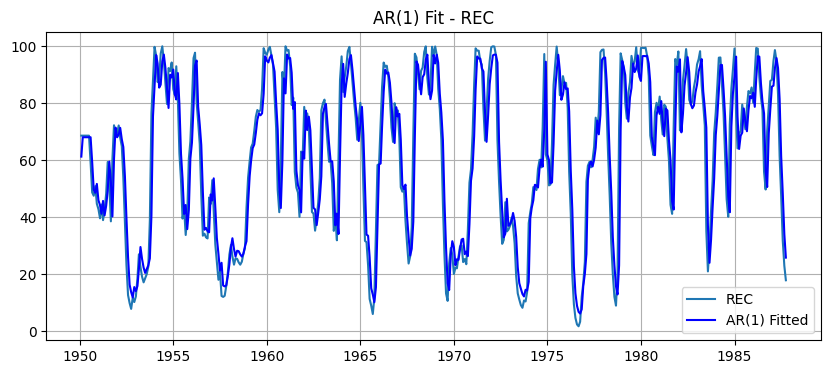

In [9]:
# === Fit AR(1) ===
fit_ar1 = ARIMA(rec_ts, order=(1, 0, 0)).fit()
ar1_params = fit_ar1.params.values

plt.figure(figsize=(10, 4))
plt.plot(rec_ts, label="REC")
plt.plot(rec_ts.index, rec_ts - fit_ar1.resid, label="AR(1) Fitted", color='blue')
plt.legend()
plt.title("AR(1) Fit - REC")
plt.grid(True)
plt.show()

In [ ]:
# =============================================================================
# 7. IMA(1) & EWMA 概念示範
# =============================================================================

# 7.1 IMA(1) 擬合 (差分後 MA(1))
ima1_mod = ARIMA(rec_ts, order=(0,1,1)).fit()
theta = ima1_mod.params['ma.L1']
lambda_est = 1 + theta  # 理論上 EWMA λ ≈ 1 + θ

# 7.2 自訂 EWMA 函數
def ewma(series, lam):
    s = np.zeros_like(series)
    s[0] = series[0]
    for t in range(1,len(series)):
        s[t] = lam * series[t] + (1-lam) * s[t-1]
    return s

ewma_est   = ewma(rec, lambda_est)
ewma_fixed = ewma(rec, 0.1)

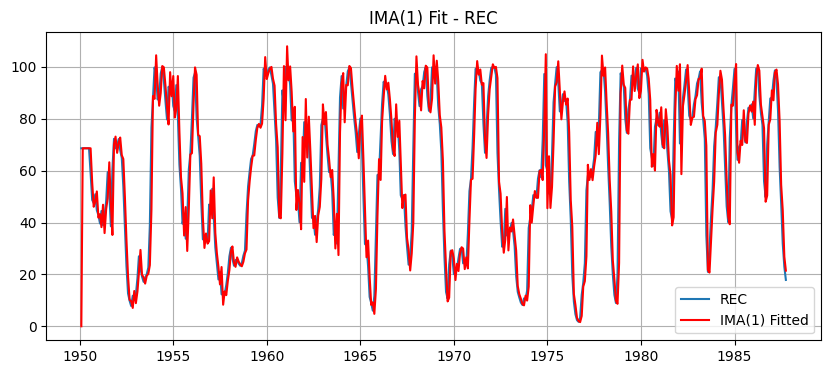

In [30]:
# === Fit IMA(1) ===
ima1_params = ima1_mod.params.values

plt.figure(figsize=(10, 4))
plt.plot(rec_ts, label="REC")
plt.plot(rec_ts.index, rec_ts - ima1_mod.resid, label="IMA(1) Fitted", color='red')
plt.legend()
plt.title("IMA(1) Fit - REC")
plt.grid(True)
plt.show()

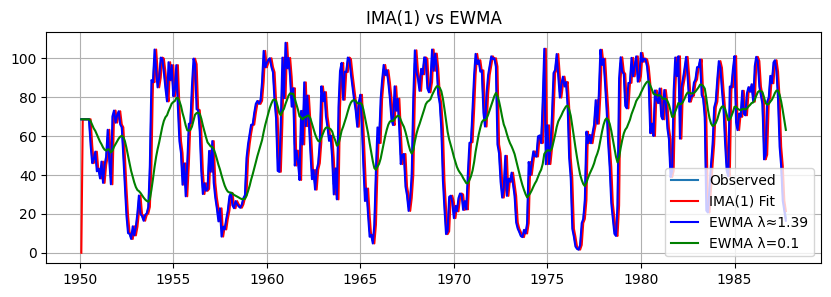

In [31]:
plt.figure(figsize=(10,3))
plt.plot(rec_ts, label='Observed')
plt.plot(rec_index, rec - ima1_mod.resid, label='IMA(1) Fit', color='red')
plt.plot(rec_index, ewma_est,   label=f'EWMA λ≈{lambda_est:.2f}', color='blue')
plt.plot(rec_index, ewma_fixed, label='EWMA λ=0.1', color='green')
plt.title('IMA(1) vs EWMA'); plt.legend(); plt.grid(); plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  453
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -1644.076
Date:                            Fri, 20 Jun 2025   AIC                           3298.153
Time:                                    16:05:39   BIC                           3318.732
Sample:                                01-31-1950   HQIC                          3306.262
                                     - 09-30-1987                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9275      0.023     39.585      0.000       0.882       0.973
ma.L1          0.3134      0.045   

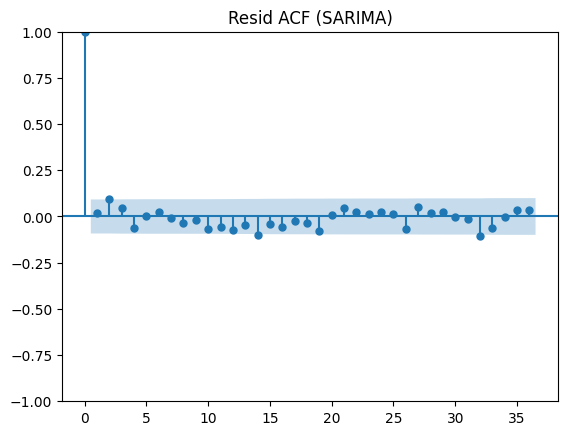

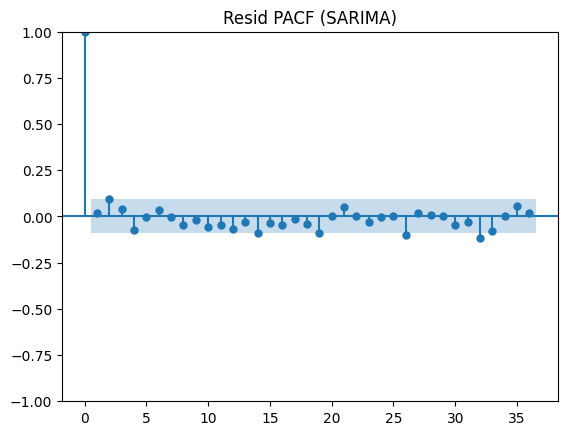

Ljung-Box (SARIMA):
       lb_stat  lb_pvalue
12  13.842631    0.31087


In [40]:
# =============================================================================
# 5. SARIMA 模型（加入季節成分）
# =============================================================================

# 5.1 SARIMA(1,0,1)(1,0,1)[12]：適用於月度資料有短期自相關+年度季節
sarima_rec = SARIMAX(rec_ts,
                     order=(1,0,1),
                     seasonal_order=(1,0,1,12)).fit(disp=False)
print(sarima_rec.summary())

# 5.2 殘差診斷
resid_s = sarima_rec.resid.dropna()
plot_acf(resid_s, lags=36, title='Resid ACF (SARIMA)'); plt.show()
plot_pacf(resid_s, lags=36, method='ywm', title='Resid PACF (SARIMA)'); plt.show()
print('Ljung-Box (SARIMA):\n', acorr_ljungbox(resid_s, lags=[12], return_df=True))


In [43]:
# 5.3 SARIMA 預測 ±1 SE
sfc = sarima_rec.get_forecast(steps=24)
smean, sci = sfc.predicted_mean, sfc.conf_int()
print(smean, sci)

1987-10-31    27.483331
1987-11-30    34.182909
1987-12-31    40.366114
1988-01-31    42.238083
1988-02-29    42.993134
1988-03-31    42.698450
1988-04-30    40.627468
1988-05-31    37.783718
1988-06-30    33.051532
1988-07-31    27.147178
1988-08-31    25.756311
1988-09-30    34.204447
1988-10-31    46.465037
1988-11-30    51.781500
1988-12-31    56.681906
1989-01-31    57.367082
1989-02-28    57.022154
1989-03-31    55.708023
1989-04-30    52.692904
1989-05-31    48.974194
1989-06-30    43.432111
1989-07-31    36.777760
1989-08-31    34.688119
1989-09-30    42.480617
Freq: ME, Name: predicted_mean, dtype: float64               lower y     upper y
1987-10-31  10.053721   44.912940
1987-11-30   6.407778   61.958039
1987-12-31   6.108040   74.624188
1988-01-31   3.257732   81.218435
1988-02-29   0.367657   85.618611
1988-03-31  -2.829395   88.226296
1988-04-30  -7.256119   88.511055
1988-05-31 -12.036838   87.604275
1988-06-30 -18.376399   84.479463
1988-07-31 -25.623706   79.918062
198

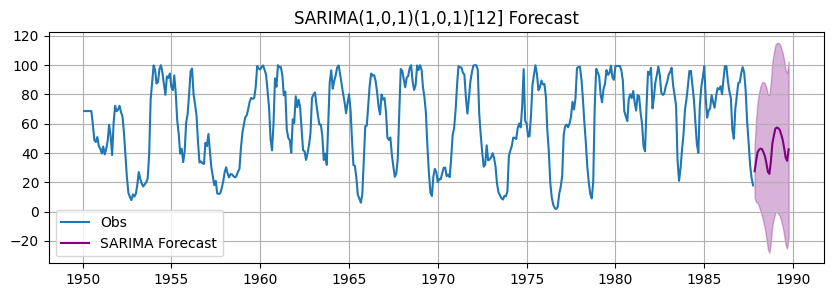

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(rec_ts,        label='Obs')
plt.plot(smean.index, smean, color='purple', label='SARIMA Forecast')
plt.fill_between(sci.index, sci.iloc[:,0], sci.iloc[:,1], color='purple', alpha=0.3)
plt.title('SARIMA(1,0,1)(1,0,1)[12] Forecast'); plt.legend(); plt.grid(); plt.show()

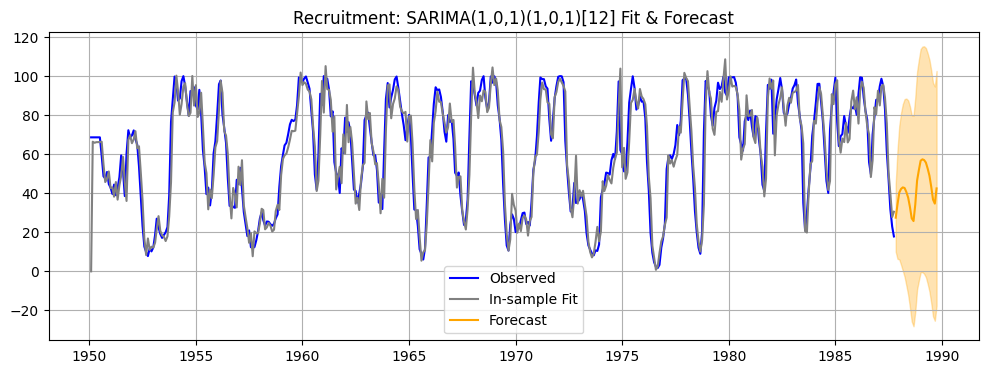

In [50]:
# SARIMA model
# sarima_rec = SARIMAX(rec_ts, order=(1,0,1), seasonal_order=(1,0,1,12)).fit(disp=False)
rec_fit = sarima_rec.predict(start=rec_ts.index[0], end=rec_ts.index[-1])
rec_fc = sarima_rec.get_forecast(steps=24)
rec_mean = rec_fc.predicted_mean
rec_ci = rec_fc.conf_int()

# Convert confidence interval columns to float arrays
ci_lower = rec_ci.iloc[:,0].astype(float).to_numpy()
ci_upper = rec_ci.iloc[:,1].astype(float).to_numpy()

plt.figure(figsize=(12,4))
plt.plot(rec_ts, label='Observed', color='blue')
plt.plot(rec_ts.index, rec_fit, label='In-sample Fit', color='gray')
plt.plot(rec_mean.index, rec_mean, label='Forecast', color='orange')
plt.fill_between(rec_mean.index, ci_lower, ci_upper, color='orange', alpha=0.3)
plt.title('Recruitment: SARIMA(1,0,1)(1,0,1)[12] Fit & Forecast')
plt.legend(); plt.grid(); plt.show()

<Figure size 800x200 with 0 Axes>

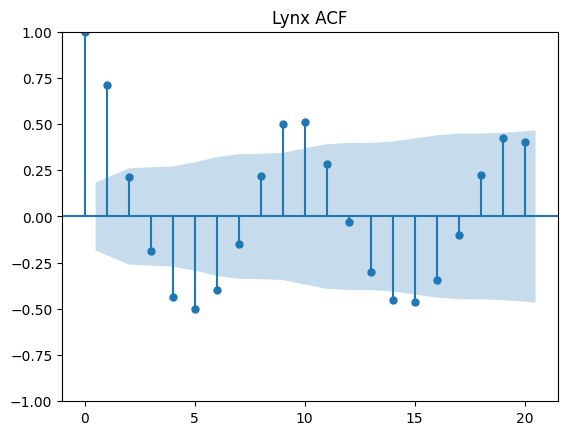

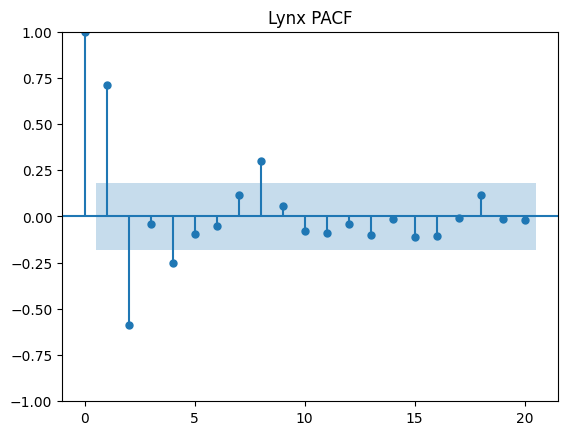

In [32]:
# =============================================================================
# 8. 週期資料 Lynx：同樣流程示範 AR(2)
# =============================================================================

plt.figure(figsize=(8,2))
plot_acf(lynx_ts, lags=20, title='Lynx ACF'); plt.show()
plot_pacf(lynx_ts, lags=20, method='ywm', title='Lynx PACF'); plt.show()

In [33]:
lynx_mod = ARIMA(lynx_ts, order=(2,0,0)).fit()
print(lynx_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  114
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -935.020
Date:                Fri, 20 Jun 2025   AIC                           1878.041
Time:                        15:24:35   BIC                           1888.985
Sample:                    12-31-1821   HQIC                          1882.483
                         - 12-31-1934                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1538.0176    258.564      5.948      0.000    1031.241    2044.794
ar.L1          1.1473      0.064     17.871      0.000       1.021       1.273
ar.L2         -0.5996      0.085     -7.079      0.0

In [35]:
# 根與週期性分析
phi1, phi2 = lynx_mod.params[:2]
roots = np.roots([1, -phi1, -phi2])
modulus = np.abs(roots)
period  = 2*np.pi/np.angle(roots)
print('Roots modulus =', modulus, '→ Periodicity ≈', period)

Roots modulus = [1.53801831e+03 7.45965507e-04] → Periodicity ≈ [inf  2.]


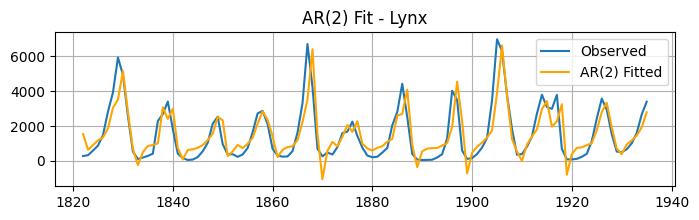

In [36]:
plt.figure(figsize=(8,2))
plt.plot(lynx_ts, label='Observed')
plt.plot(lynx_ts.index, lynx_ts-lynx_mod.resid, label='AR(2) Fitted', color='orange')
plt.title('AR(2) Fit - Lynx'); plt.legend(); plt.grid(); plt.show()


In [37]:
# Forecast 10 steps ahead
forecast_lynx = lynx_mod.get_forecast(steps=10)
forecast_values = forecast_lynx.predicted_mean
print(forecast_values)

1935-12-31    2998.727541
1936-12-31    2099.810930
1937-12-31    1306.690456
1938-12-31     935.748922
1939-12-31     985.738966
1940-12-31    1265.518602
1941-12-31    1556.536933
1942-12-31    1722.662049
1943-12-31    1738.757106
1944-12-31    1657.610416
Freq: YE-DEC, Name: predicted_mean, dtype: float64


In [45]:
# =============================================================================
# 6. Lynx 年度資料：示範非月度但仍可嘗試 SARIMA
# =============================================================================
# 6.2 AR(2) vs SARIMA(2,0,0)(1,0,1)[10]
#     選 s=10 僅為示範用（年度也可有 10 年循環）
lynx_sarima = SARIMAX(lynx_ts,
                     order=(2,0,0),
                     seasonal_order=(1,0,1,10)).fit(disp=False)
print(lynx_sarima.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  114
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 10)   Log Likelihood                -937.642
Date:                              Fri, 20 Jun 2025   AIC                           1885.284
Time:                                      16:08:51   BIC                           1898.965
Sample:                                  12-31-1821   HQIC                          1890.836
                                       - 12-31-1934                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0122      0.067     15.169      0.000       0.881       1.143
ar.L2         -0.37

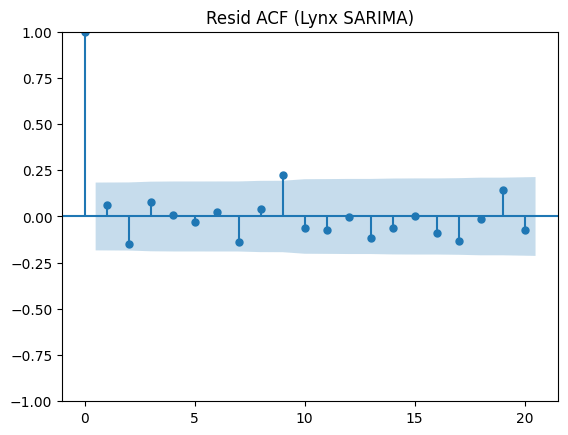

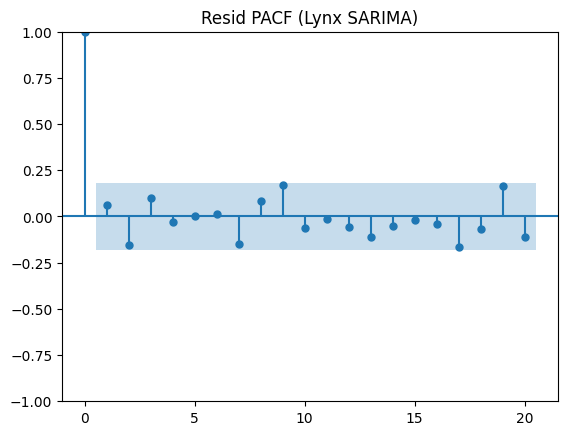

Ljung-Box (Lynx SARIMA):
       lb_stat  lb_pvalue
10  13.240594   0.210529


In [46]:
# 6.3 殘差診斷
rs = lynx_sarima.resid.dropna()
plot_acf(rs, lags=20, title='Resid ACF (Lynx SARIMA)'); plt.show()
plot_pacf(rs, lags=20, method='ywm', title='Resid PACF (Lynx SARIMA)'); plt.show()
print('Ljung-Box (Lynx SARIMA):\n', acorr_ljungbox(rs, lags=[10], return_df=True))

In [47]:
# 6.4 Forecast
lfc = lynx_sarima.get_forecast(steps=10)
lmean, lci = lfc.predicted_mean, lfc.conf_int()
print(lmean, lci)

1935-12-31    3567.398751
1936-12-31    2802.579341
1937-12-31    1020.822133
1938-12-31     235.119171
1939-12-31     175.329108
1940-12-31     308.907682
1941-12-31     551.290186
1942-12-31     984.238138
1943-12-31    1778.787697
1944-12-31    2478.825752
Freq: YE-DEC, Name: predicted_mean, dtype: float64                 lower y      upper y
1935-12-31  1852.836079  5281.961423
1936-12-31   363.010851  5242.147832
1937-12-31 -1658.511743  3700.156009
1938-12-31 -2484.216789  2954.455130
1939-12-31 -2544.487916  2895.146132
1940-12-31 -2413.732505  3031.547868
1941-12-31 -2175.200263  3277.780635
1942-12-31 -1744.075815  3712.552091
1943-12-31  -949.916174  4507.491567
1944-12-31  -249.892806  5207.544310


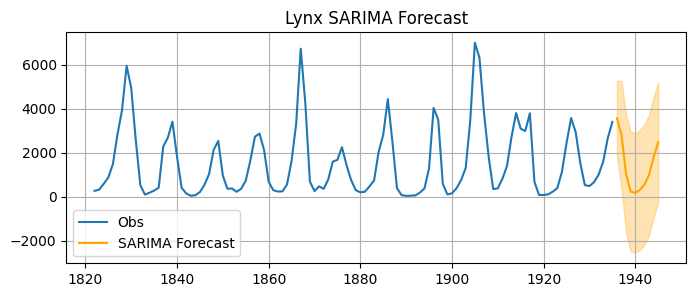

In [48]:
plt.figure(figsize=(8,3))
plt.plot(lynx_ts, label='Obs')
plt.plot(lmean.index, lmean, color='orange', label='SARIMA Forecast')
plt.fill_between(lci.index, lci.iloc[:,0], lci.iloc[:,1], color='orange', alpha=0.3)
plt.title('Lynx SARIMA Forecast'); plt.legend(); plt.grid(); plt.show()

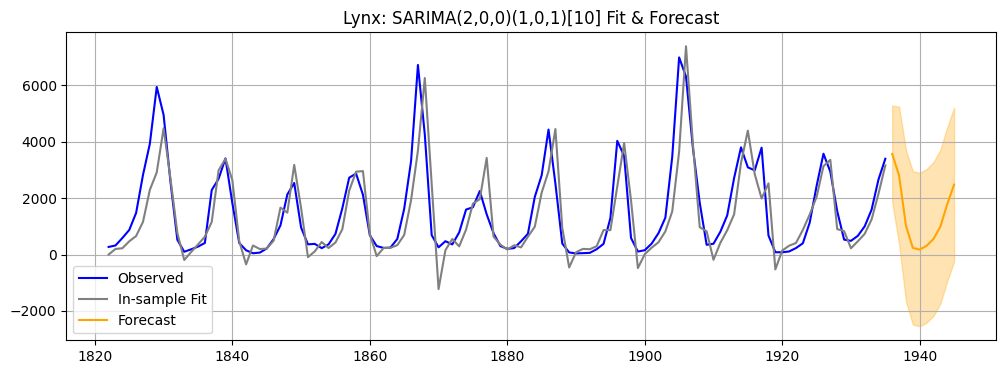

In [51]:
#lynx_sarima = SARIMAX(lynx_ts, order=(2,0,0), seasonal_order=(1,0,1,10)).fit(disp=False)
lynx_fit = lynx_sarima.predict(start=lynx_ts.index[0], end=lynx_ts.index[-1])
lynx_fc = lynx_sarima.get_forecast(steps=10)
lynx_mean = lynx_fc.predicted_mean
lynx_ci = lynx_fc.conf_int()

ci_lower_l = lynx_ci.iloc[:,0].astype(float).to_numpy()
ci_upper_l = lynx_ci.iloc[:,1].astype(float).to_numpy()

plt.figure(figsize=(12,4))
plt.plot(lynx_ts, label='Observed', color='blue')
plt.plot(lynx_ts.index, lynx_fit, label='In-sample Fit', color='gray')
plt.plot(lynx_mean.index, lynx_mean, label='Forecast', color='orange')
plt.fill_between(lynx_mean.index, ci_lower_l, ci_upper_l, color='orange', alpha=0.3)
plt.title('Lynx: SARIMA(2,0,0)(1,0,1)[10] Fit & Forecast')
plt.legend(); plt.grid(); plt.show()